In [2]:
!pip install rfdetr
!pip install supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 8.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.8/372.8 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 40.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 113.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━

In [8]:
import gc
import torch
import weakref

def cleanup_gpu_memory(obj=None, verbose: bool = False):

    if not torch.cuda.is_available():
        if verbose:
            print("[INFO] CUDA is not available. No GPU cleanup needed.")
        return

    def get_memory_stats():
        allocated = torch.cuda.memory_allocated()
        reserved = torch.cuda.memory_reserved()
        return allocated, reserved

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[Before] Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

    # Ensure we drop all strong references
    if obj is not None:
        ref = weakref.ref(obj)
        del obj
        if ref() is not None and verbose:
            print("[WARNING] Object not fully garbage collected yet.")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[After]  Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

In [9]:
cleanup_gpu_memory(model, verbose=True)

[Before] Allocated: 117.05 MB | Reserved: 134.00 MB
[WARNING] Object not fully garbage collected yet.
[After]  Allocated: 117.05 MB | Reserved: 134.00 MB


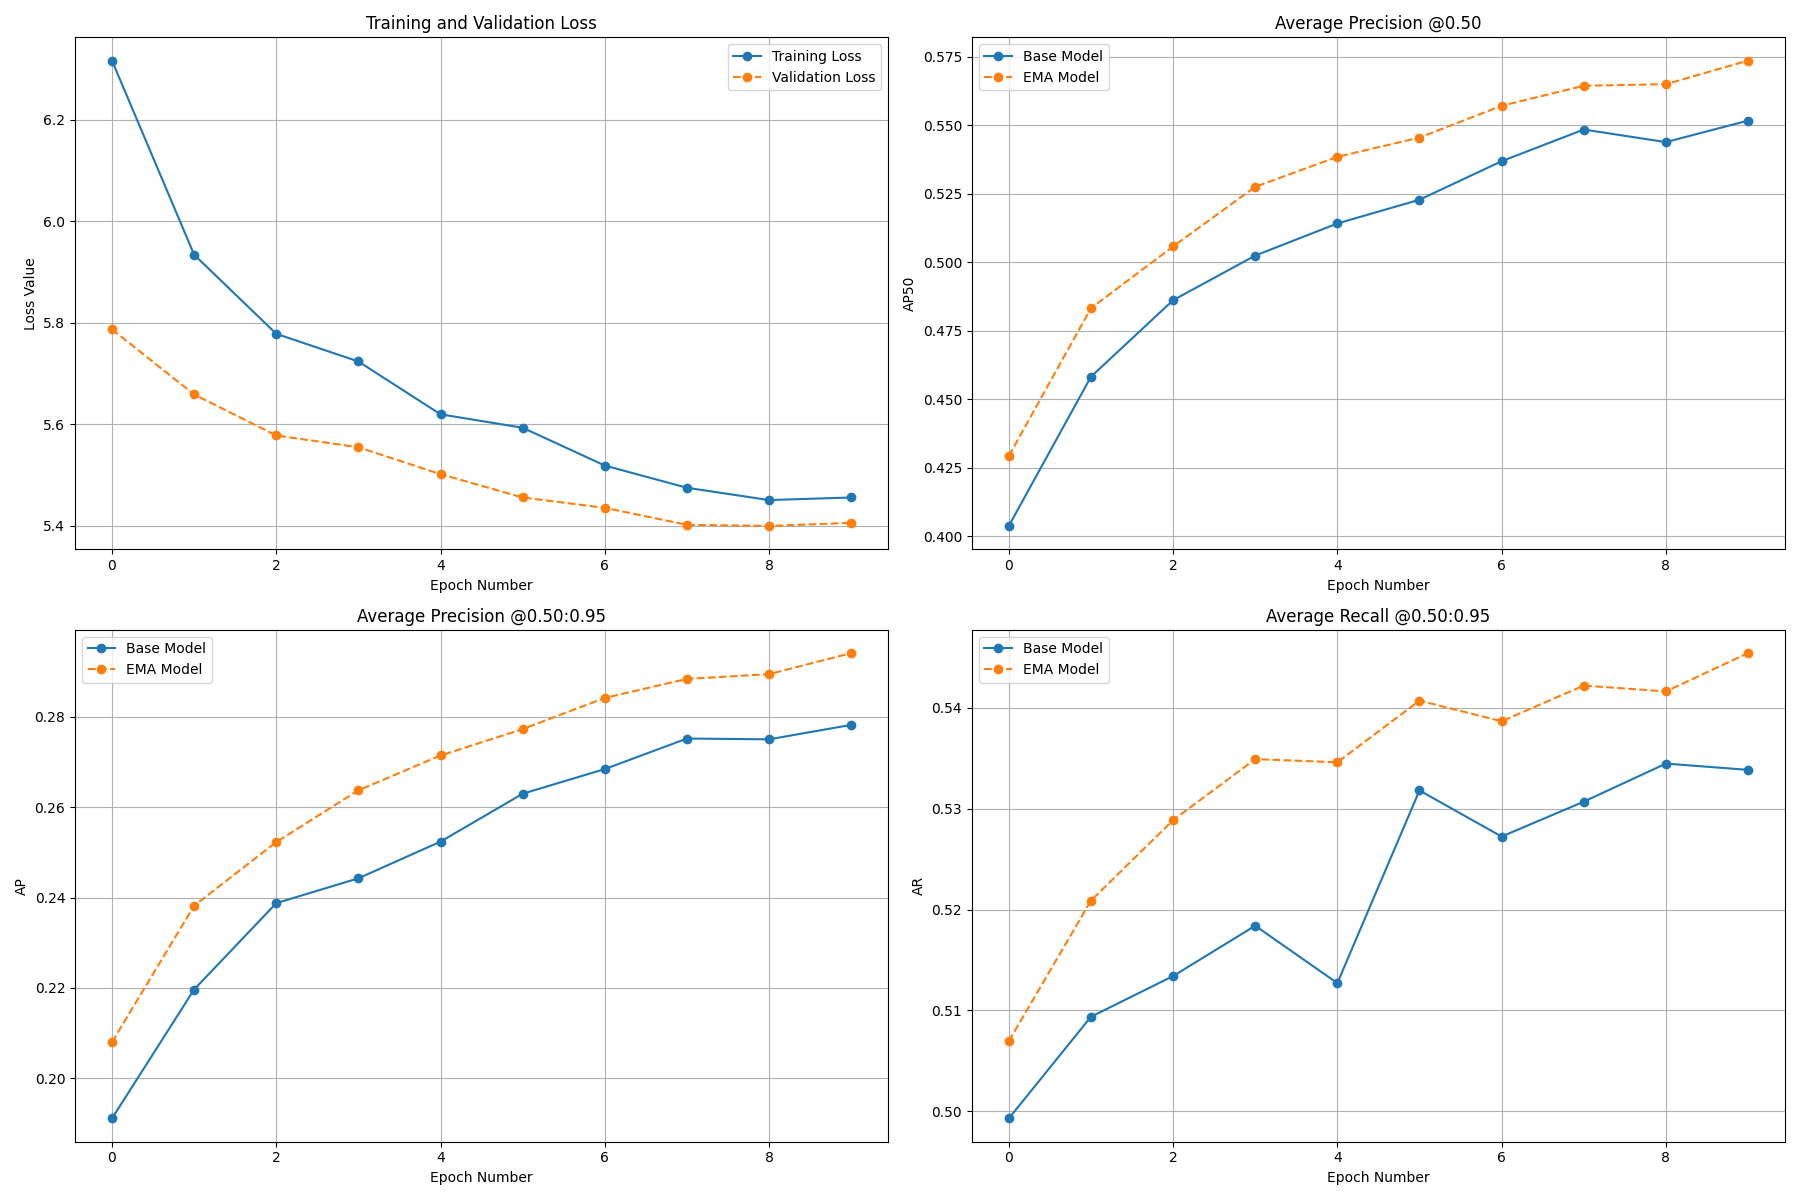

In [15]:
from PIL import Image

Image.open("/kaggle/working/rfdetr-p100/metrics_plot.png")

In [6]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path="/kaggle/input/roadhealthdetector/randomized_dataset/train",
    annotations_path="/kaggle/input/roadhealthdetector/randomized_dataset/train/_annotations.coco.json",
)

In [ ]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0)

    targets.append(annotations)
    predictions.append(detections)

 73%|███████▎  | 19148/26385 [27:50<18:50,  6.40it/s] 

In [8]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
print(map_result)

Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.358
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.655
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.339
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.164
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.288
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.434


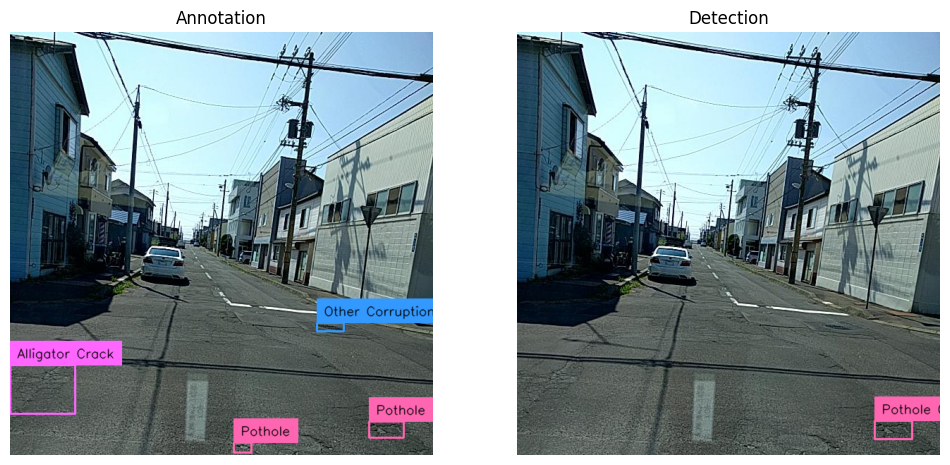

In [9]:
from rfdetr import RFDETRNano
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

bbox_annotator = sv.BoxAnnotator(color=color,thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

In [4]:
from rfdetr import RFDETRNano
from PIL import Image
import os

# Load model with best EMA weights
model = RFDETRNano(pretrain_weights="/kaggle/input/roadhealthdetector/rfdetr-p100/checkpoint_best_ema.pth")
# Pick a test image
test_dir = '/kaggle/input/roadhealthdetector/randomized_dataset/test/'
test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
img_path = os.path.join(test_dir, test_images[0])
image = Image.open(img_path)

# Run prediction
detections = model.predict(image, threshold=0.3)

# Print the output type and a sample
print('Type:', type(detections))
print('Detections:', detections)
if hasattr(detections, 'to_dict'):
    print('As dict:', detections.to_dict())
if hasattr(detections, 'class_id') and hasattr(detections, 'xyxy') and hasattr(detections, 'confidence'):
    print('class_id:', detections.class_id)
    print('xyxy:', detections.xyxy)
    print('confidence:', detections.confidence)

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


Type: <class 'supervision.detection.core.Detections'>
Detections: Detections(xyxy=array([[225.8767, 435.4308, 313.9454, 455.4877]], dtype=float32), mask=None, confidence=array([0.34031457], dtype=float32), class_id=array([1]), tracker_id=None, data={}, metadata={})
class_id: [1]
xyxy: [[225.8767 435.4308 313.9454 455.4877]]
confidence: [0.34031457]


In [5]:
import os
from PIL import Image
from rfdetr import RFDETRNano
import numpy as np
from tqdm import tqdm

# Load model
model = RFDETRNano(pretrain_weights="/kaggle/input/roadhealthdetector/rfdetr-p100/checkpoint_best_ema.pth")
# Do NOT call optimize_for_inference()

test_dir = '/kaggle/input/roadhealthdetector/randomized_dataset/test/'
pred_dir = 'predictions'
os.makedirs(pred_dir, exist_ok=True)

test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

for img_name in tqdm(test_images):
    img_path = os.path.join(test_dir, img_name)
    image = Image.open(img_path)
    w, h = image.size
    detections = model.predict(image, threshold=0.3)
    # Prepare lines for YOLO format
    lines = []
    if hasattr(detections, 'class_id') and hasattr(detections, 'xyxy') and hasattr(detections, 'confidence'):
        for cls, box, conf in zip(detections.class_id, detections.xyxy, detections.confidence):
            x_min, y_min, x_max, y_max = box
            x_center = ((x_min + x_max) / 2) / w
            y_center = ((y_min + y_max) / 2) / h
            width = (x_max - x_min) / w
            height = (y_max - y_min) / h
            line = f'{int(cls)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f} {conf:.6f}'
            lines.append(line)
    # Write to file
    txt_name = os.path.splitext(img_name)[0] + '.txt'
    with open(os.path.join(pred_dir, txt_name), 'w') as f:
        f.write('\n'.join(lines))

# Zip the predictions folder
import shutil
shutil.make_archive('submission', 'zip', pred_dir)
print('Submission zip created: submission.zip')

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


100%|██████████| 6000/6000 [07:24<00:00, 13.50it/s]


Submission zip created: submission.zip
